## 주가 예측 | ARIMA
5년간 삼성전자 주가 데이터를 이용하여 최근 주가와 예측 주가를 비교하고자 함  

Model : ARIMA & SARIMA Model 

Data_Range : from Sep 06, 2016 to Sep 06, 2021 [참고: [Yahoo finance](https://finance.yahoo.com/quote/005930.KS/history?p=005930.KS)]  




In [69]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
# plt.style.use(['fivethirtyeight'])
plt.style.use(['bmh'])

import os 
from pathlib import Path
import datetime

import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller # stationary 확인 
from statsmodels.tsa.seasonal import seasonal_decompose # decomposition

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.graphics.tsaplots as sgt 

from statsmodels.tsa.arima_model import ARIMA
# from pmdarima.arima import auto_arima # ARIMA parameter auto 확인 
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math 


In [70]:
# plt.style.available

### **1. Data 세팅 및 전처리** 

#### 1-1. 데이터 세팅 

In [71]:
dataset_path = Path(os.getcwd() + '/data/samsung_005930.KS.csv')
samsung = pd.read_csv(dataset_path, index_col= 'Date', parse_dates= True)
samsung.head()


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-09-06,32140.0,32900.0,31940.0,32860.0,28340.804688,7660150.0
2016-09-07,32960.0,33040.0,32420.0,32420.0,27961.316406,9591850.0
2016-09-08,32460.0,32780.0,32280.0,32780.0,28271.812500,12070850.0
2016-09-09,32220.0,32360.0,31280.0,31500.0,27167.845703,13258400.0
2016-09-12,29800.0,30120.0,29120.0,29300.0,25270.406250,26499350.0


#### 1-2. null값 확인 및 대치 
- null 값이 존재한다면 time 기준으로 데이터 대치 

In [72]:
samsung.isnull().sum() # 5줄 나옴 

samsung[samsung.isnull().any(axis = 1)]


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-11-16,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-23,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02,NaN,NaN,NaN,NaN,NaN,NaN
2018-11-15,NaN,NaN,NaN,NaN,NaN,NaN
2019-11-14,NaN,NaN,NaN,NaN,NaN,NaN


In [73]:
samsung_m = samsung.interpolate(method = 'time')
samsung_m.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

#### 1-3. Plot으로 데이터 확인 

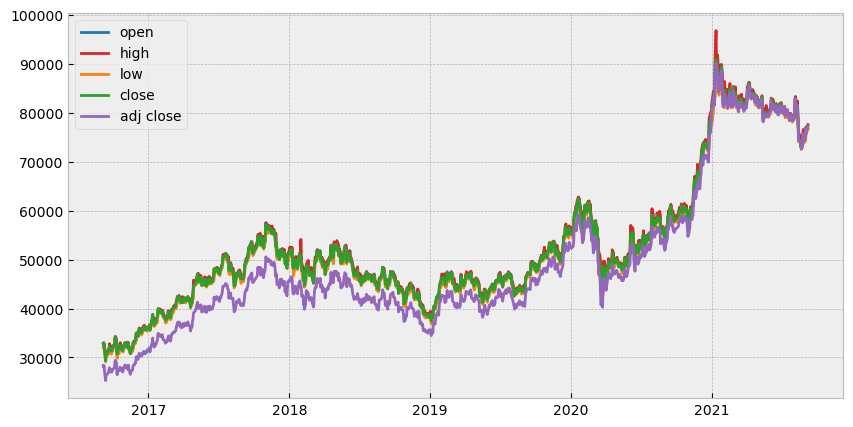

In [74]:
rcParams['figure.figsize'] = 10, 5
plt.plot(samsung_m['Open'], color = 'tab:blue', label = 'open')
plt.plot(samsung_m['High'], color = 'tab:red', label = 'high')
plt.plot(samsung_m['Low'], color = 'tab:orange', label = 'low')
plt.plot(samsung_m['Close'], color = 'tab:green', label = 'close')
plt.plot(samsung_m['Adj Close'], color = 'tab:purple', label = 'adj close')
plt.legend(loc = 'best')
plt.show()

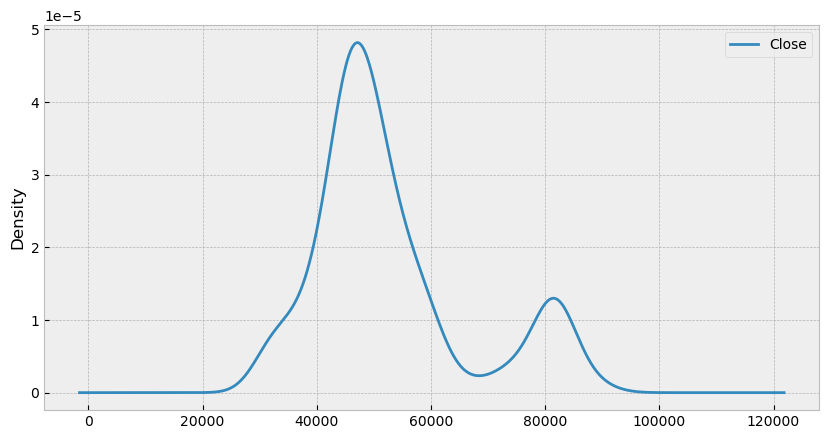

In [75]:
# kde plot | close 가격 확률밀도 함수 확인
samsung_m['Close'].plot(kind = 'kde')
plt.legend(loc = 'best')
plt.show()

***[TIP]***  

수정 주가(Adjusted Closing Price)는 기업 행동을 고려한 후 해당 주식의 가치를 반영하기 위해 종가를 수정한 것을 말하며, 영어 단어 그대로는 조정된 종가를 의미합니다. 수정 주가는 과거 수익률을 조사하거나 과거 실적을 상세하게 분석할 때 자주 사용됩니다.  

[참고페이지](https://mindex.kr/posts/adjusted-closing-price/)

> **이번에는 Close 가격만을 사용하여 시계열 분석을 진행하고자 함**

In [76]:
# 종가 데이터만 따로 저장 
ts = samsung_m['Close']
ts.head()

Date
2016-09-06    32860.0
2016-09-07    32420.0
2016-09-08    32780.0
2016-09-09    31500.0
2016-09-12    29300.0
Name: Close, dtype: float64

> 추가적인 데이터 전처리는 추후 데이터를 확인하면서 진행하고자 함  

<br>

### 2. Data Stationary 정도 확인  
|번호|내용|
|:------:|------|
|1|시계열 데이터로 취급하기 위해서는 안정성의 특성이 존재해야 함  |
|2|데이터 구간별로 mean, variance, covariance가 동일해야 함  |
|3|이를 이동평균값으로 확인하고자 함, 여기서는 단순이동평균값을 사용  |
|4|이동평균이란 수의 집합에서 특정 x 크기의 부분집합을 연속적으로 이동하며 산출한 평균|

기준1. 5 days(Monday to Friday)  

기준2. 20 days (4 weeks)


#### 2-1. 눈대중으로 Stationary 정도 확인

In [77]:
def plot_rolling_data(data, window = 5):
    rollmean = data.rolling(window = window).mean()
    rollstd = data.rolling(window = window).std()
    print(rollstd.count())
    # 구간별 평균, 표준편차, original 값 확인하기 위해 plotting
    orig = plt.plot(data, color = 'tab:blue', label = 'orig')
    avg = plt.plot(rollmean, color = 'tab:green', label = 'avg')
    std = plt.plot(rollstd, color = 'tab:orange', label = 'std')
    plt.legend(loc = 'best')
    plt.title('Rolling Stock Close Price_Orig, Avg, Std')
    plt.show()

1224


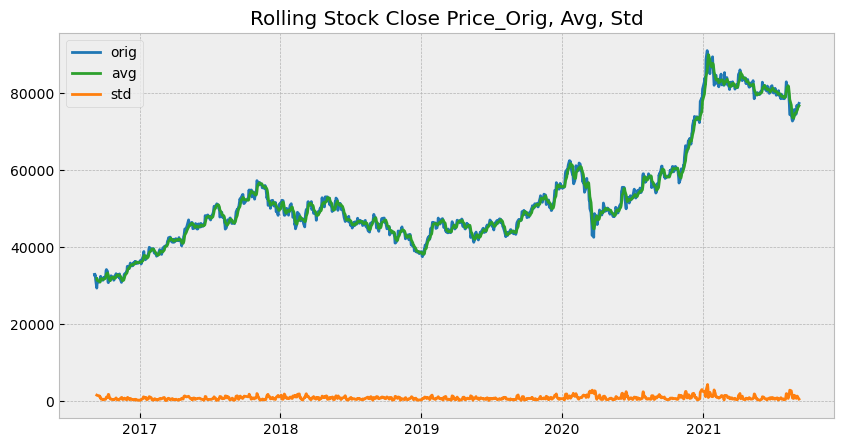

In [78]:
# window = 5, timeslot 5일
# timeslot 1224개

plot_rolling_data(ts, window = 5)

> 데이터 개수가 많아서 눈에 잘 보이지 않는 듯 하여 일부 구간만 따로 plot해봄 

206


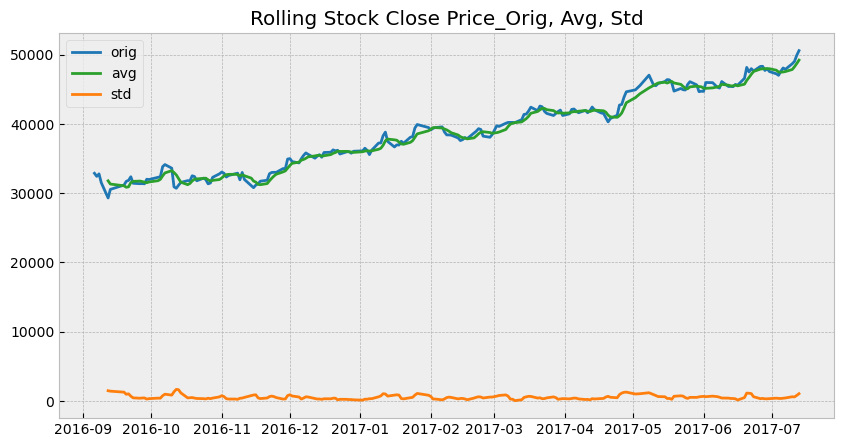

In [79]:
plot_rolling_data(ts[:210], window = 5)

> 1. window를 5로 한 것이 문제인 것 같음. 너무 짧은 rolling 구간인 듯 싶음  

> 2. window를 20(4weeks), 60(3months), 120(6months) 기준으로 진행하고자 함  


1209


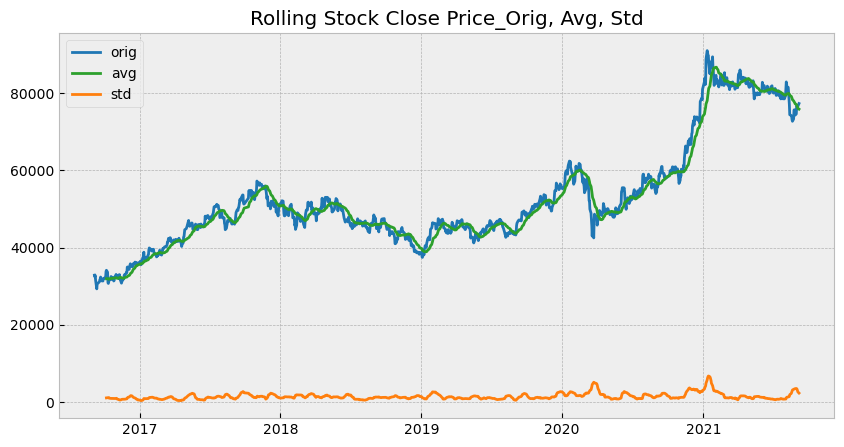

In [80]:
# window = 20days (4주)
# timeslot 1209개 
plot_rolling_data(ts, window = 20)

1169


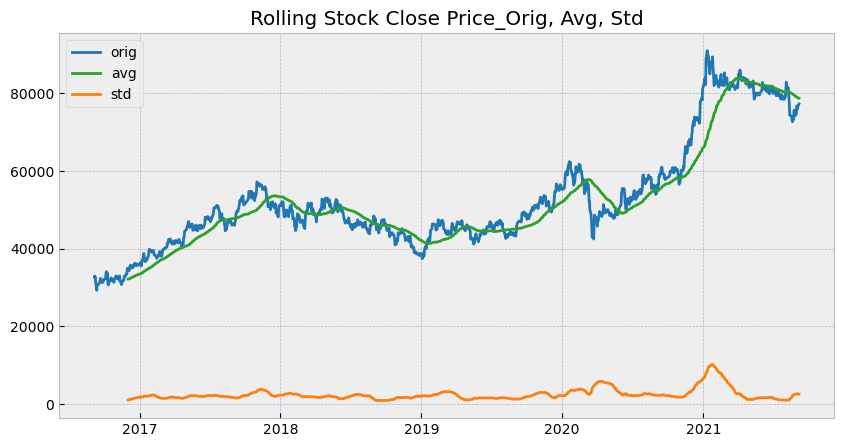

In [81]:
# window = 60 3개월(분기)
# timeslot 1169개 
plot_rolling_data(ts, window = 60)

1109


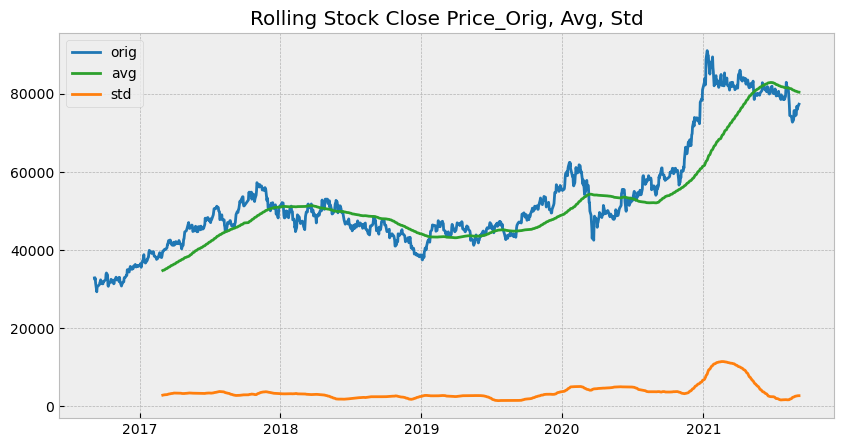

In [82]:
# window = 120 6개월(반기)
# 이렇게 되면 총 timeslot이 
plot_rolling_data(ts, window = 120)

> 1. 어떤 rolling 기준으로 보던 해당 데이터는 안정적이지 않음  
<br>

> 2. 평균도 일정하지 않고, 분산도 일정하지 않음. 즉, Non-Stationary Data  
<br>

> 3. 추가 데이터 managing이 필요함  

<br>

#### 2-2. 통계적 방법으로 Stationary 정도 확인
Augmented Dickey-Fuller Test(ADF) 사용  

`.statsmodels.tsa.stattools`

In [83]:
def augmented_dickey_fuller(data):
    adfuller_test = adfuller(data, autolag = 'AIC')

    adfuller_test_output = pd.Series(adfuller_test[:4], 
                            index = ['test_statistic', 'pvalue', 'num_of_lags', 'num_of_observation'])
    for key, value in adfuller_test[4].items():
        adfuller_test_output['critical_values (%s)' %key] = value
    print(adfuller_test_output)

Fuction 하나 더 생성 
- 뒤에서 adfuller test의 결과 p-value 및 num of lags가 0이 나와서 
- 추가적으로 autolag 변수 변경하여 생성 
- AIC는 최소 lag 찾고, t-stat은 최대 lag 찾음

In [84]:

def augmented_dickey_fuller_2(data):
    adfuller_test = adfuller(data, autolag = 't-stat')

    adfuller_test_output = pd.Series(adfuller_test[:4], 
                            index = ['test_statistic', 'pvalue', 'num_of_lags', 'num_of_observation'])
    for key, value in adfuller_test[4].items():
        adfuller_test_output['critical_values (%s)' %key] = value
    print(adfuller_test_output)

[`statsmodels.tsa.stattools.adfuller` 참고자료](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html)  

- autolag: {“AIC”, “BIC”, “t-stat”, None}  

    : Method to use when automatically determining the lag length among the values 0, 1, …, maxlag.

    : If “AIC” (default) or “BIC”, then the number of lags is chosen to minimize the corresponding information criterion.

    : “t-stat” based choice of maxlag. Starts with maxlag and drops a lag until the t-statistic on the last lag length is significant using a 5%-sized test.

    : If None, then the number of included lags is set to maxlag.

In [85]:
augmented_dickey_fuller(ts)

test_statistic             -0.918671
pvalue                      0.781762
num_of_lags                18.000000
num_of_observation       1209.000000
critical_values (1%)       -3.435770
critical_values (5%)       -2.863934
critical_values (10%)      -2.568044
dtype: float64


> 1. p-value가 0.78로 높은 값을 갖고 있음. 즉, 데이터가 stationary하다는 귀무가설을 기각할 수 없음.  
<br>

> 2. Unstationary한 데이터를 Stationary하게 만들어야 함   

<br>

#### 2-3-1. np.log() | Unstationary to Stationary | 추가 데이터 전처리  
|방법|내용|
|:------|------|
|1. np.log|데이터 간 편차를 줄여 정규성을 높이기 위해 사용함|
|2. Decomposition|trend, seasonality 특성 제거|



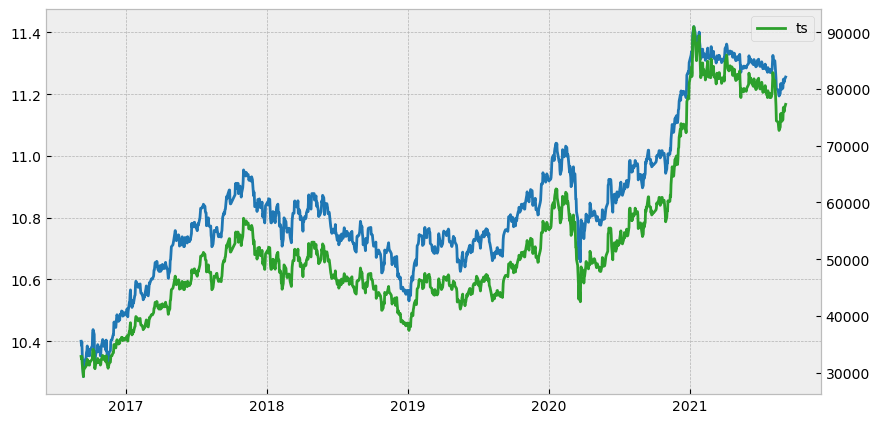

In [86]:
# np.log를 사용하여 데이터 로그화 시키기 
ts_log = np.log(ts)

# original data와 np.log화 시킨 데이터 plot
fig, ax1 = plt.subplots()
ax1.plot(ts_log, color = 'tab:blue', label = 'ts_log')

ax2 = ax1.twinx()
ax2.plot(ts, color = 'tab:green', label = 'ts')
plt.legend(loc = 'best')
plt.grid(False)
plt.show()


> log화 시킨 데이터의 Stationary 정도를 확인하고자 함 

In [87]:
augmented_dickey_fuller(ts_log)

# num of lags 0

test_statistic             -1.303605
pvalue                      0.627521
num_of_lags                 0.000000
num_of_observation       1227.000000
critical_values (1%)       -3.435691
critical_values (5%)       -2.863898
critical_values (10%)      -2.568026
dtype: float64


In [88]:
augmented_dickey_fuller_2(ts_log)

# num of lags 17

test_statistic             -1.453812
pvalue                      0.556224
num_of_lags                17.000000
num_of_observation       1210.000000
critical_values (1%)       -3.435766
critical_values (5%)       -2.863932
critical_values (10%)      -2.568043
dtype: float64


***[Question | Num of lags]***  

num_of_lags가 0이라는 것은 시차가 없다는 의미인가...? 시계열 자료가 반복적인 Pattern이 없다는 뜻인건가  

- lag length를 return하는 것이 num of lags 값인데, 이게 0라 나오는 것을 보면  
<br>

- [참고자료](https://stackoverflow.com/questions/47349422/how-to-interpret-adfuller-test-results)Third data point: 0: Number of lags used in regression to determine t-statistic. So there are no auto correlations going back to '0' periods here.  
<br>  

- [How do you choose the optimal laglength in a time series?](https://www.researchgate.net/post/How-do-you-choose-the-optimal-laglength-in-a-time-series)  

- [Choosing the Lag Length for the ADF Test](https://faculty.washington.edu/ezivot/econ584/notes/unitrootLecture2.pdf)
    - An important practical issue for the implementation of the ADF test is the specification of the lag length p.  

    - If p is too small then the remaining serial correlation in the errors will bias the test.

> 이전의 p-value보다 낮은 값이 나왔지만 아직도 Stationary에 가까워지지 못함  
<br>

#### 2-3-2. Decomposition | Unstationary to Stationary | 추가 데이터 전처리  
ts_log를 이용하여 데이터의 trend 및 seasonality를 제거하고자 함  

`from statsmodels.tsa.seasonal import seasonal_decompose`사용 

In [89]:
ts_log

Date
2016-09-06    10.400011
2016-09-07    10.386531
2016-09-08    10.397574
2016-09-09    10.357743
2016-09-12    10.285343
                ...    
2021-08-31    11.247657
2021-09-01    11.248960
2021-09-02    11.238489
2021-09-03    11.246352
2021-09-06    11.255449
Name: Close, Length: 1228, dtype: float64

In [90]:
type(ts_log.index)

pandas.core.indexes.datetimes.DatetimeIndex

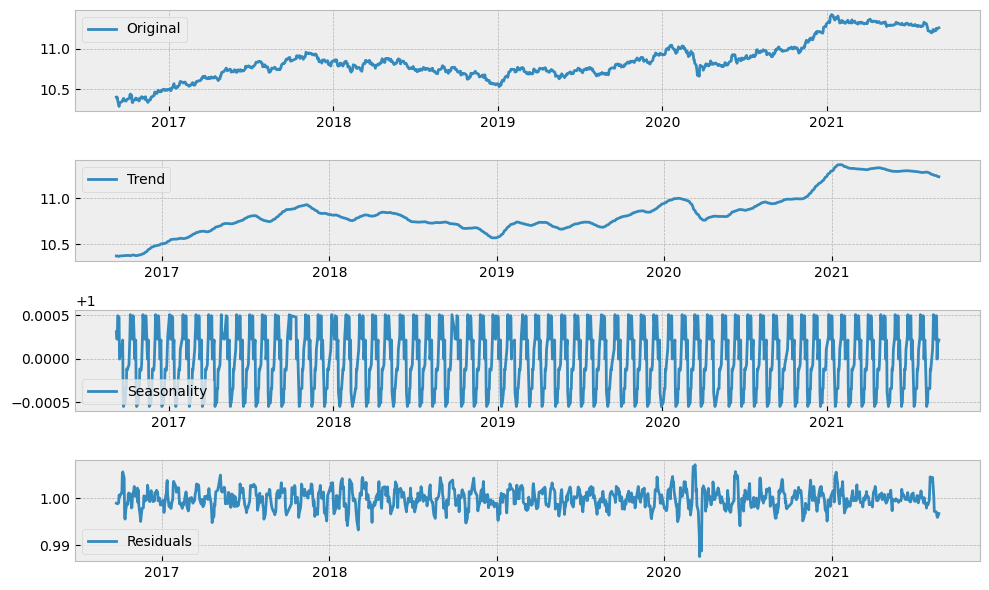

In [91]:
# period = 20, 즉 4주(한달) 주기로 진행 
# 시간폭에 따라 변화가 존재하기 때문에 multiplicative로 진행 
decomposition = seasonal_decompose(ts_log, model = 'multiplicative', 
                                    period = 20)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid # original - trend - seasonal

plt.rcParams['figure.figsize'] = (10, 6)
plt.subplot(411)
plt.plot(ts_log, label = 'Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonality')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Residuals')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()



> 1. Moving Average로 trend를 측정하고, trend를 원 데이터에서 제거하여 seasonality를 도출한 뒤, seasonality를 0점 조정  
<br>

> 2. Trend 또한 상승 곡선 확인  
<br> 

> 3. original data에서 Seasonality와 Trend를 제거한 Residual 데이터 plot을 확인해보았을 때 이전보다 데이터의 fluctuation이 낮다는 것을 확인 할 수 있음   
<br> 

> 4. Residual 데이터 Stationary 확인 필요 

[`tsa.seasonal_decompose` 참고자료](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html)  

- returns `DecomposeResult` : A object with seasonal, trend, and resid attributes.

- x : array_like
    Time series. If 2d, individual series are in columns. x must contain 2 complete cycles.

- ***model***: {“additive”, “multiplicative”}, optional
    Type of seasonal component. Abbreviations are accepted.
    The additive model is Y[t] = T[t] + S[t] + e[t]
    The multiplicative model is Y[t] = T[t] * S[t] * e[t]

    The results are obtained by first estimating the trend by applying a convolution filter to the data. The trend is then removed from the series and the average of this de-trended series for each period is the returned seasonal component.  
    <br>

- ***period*** : int, optional
    Period of the series. Must be used if x is not a pandas object or if the index of x does not have a frequency. Overrides default periodicity of x if x is a pandas object with a timeseries index.

***[TIP]***  
| |Applicative Model|Multiplicative Model|
|:-----|:------|:------|
|Model|y(t) = Level+Trend+Season+Noise|y(t) = Level x Trend x Season x Noise|
|특성|시간에 따른 변화가 일정|시간에 따른 변화폭에 변동이 존재|
|Trend|선형적 상승/하락 추세|비선형적 상승/하락 추세|
|Seasonality|주기와 변화폭이 일정|주기와 변화폭이 일정하지 않음|

[참고](https://yoongaemii.github.io/seasonal_decomposition/)

In [92]:
# Null 값 처리 
# decomposition period를 20으로 진행했기 때문에 앞에 20개 데이터가 Null
residual.isnull().sum() #20

# null 값 처리 
residual.dropna(inplace = True)
augmented_dickey_fuller(residual)

test_statistic          -1.069494e+01
pvalue                   3.645127e-19
num_of_lags              2.300000e+01
num_of_observation       1.184000e+03
critical_values (1%)    -3.435885e+00
critical_values (5%)    -2.863984e+00
critical_values (10%)   -2.568071e+00
dtype: float64


> pvalue가 0.05 이하로 확인 됨. Stationary된 Data 확인함 

1089


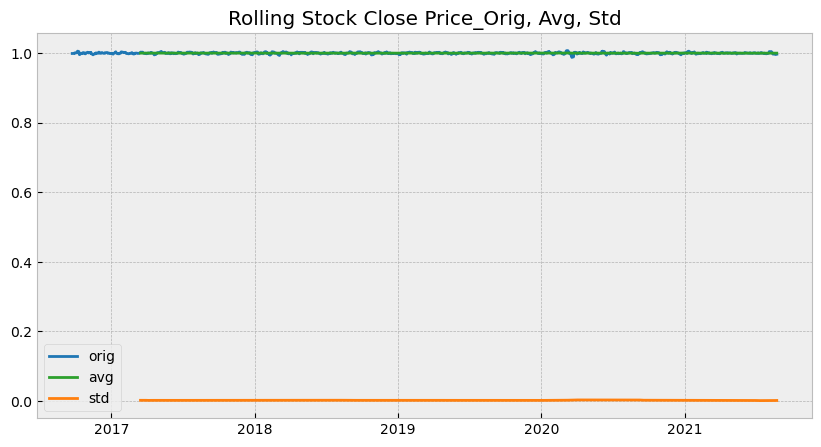

In [93]:
plt.rcParams['figure.figsize'] = 10, 5

# plot_rolling_data(residual, window = 60)
plot_rolling_data(residual, window = 120)

> 1. 위의 그래프로 보아(window를 어떻게 설정하던) 삼성전자의 주식 데이터는 Trend와 Seasonality가 확실히 도드라지는 데이터라 생각됨  
<br>

> 2. 이제부터는 AR 및 MA 특성을 한번에 파악할 수 있는 ARIMA Model을 이용해 진행할 예정이기 때문에 origin data -> ts_log를 사용하고자 함 

### **3. 학습을 위한 Train & Test 분리**

(데이터가 많지 않기 때문에) Total 데이터의 90%를 train, 10%(가장 최근의)를 test로 사용하여 predict stock price 와 actual stock price를 비교하고자 함 

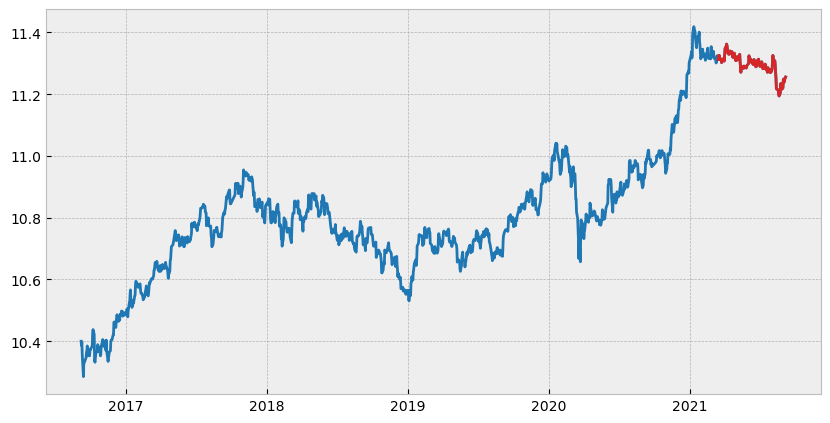

In [94]:
train, test = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

# red 부분이 우리가 예측할 부분 
plt.plot(ts_log, c ='tab:blue', label = 'train_data')
plt.plot(test, c ='tab:red', label = 'test_data')
plt.show()

In [95]:
print(len(train), len(test))

1105 123


### **4. ARIMA Model 사용_ Method 1**  

1. AutoRegressive : p. 데이터가 평균으로 수렴하는 모델. Residual에 해당하는 부분  
<br>

2. Moving Average : q. 오차값의 가중합으로 수렴하는 모델. Trend에 해당하는 부분  
<br>

3. Integration : d. 이전 데이터 + 차분의 누적합으로 수렴하는 모델. Seasonality에 해당하는 부분  
<br>  

-> Parameter 설정을 위해 ACF, PACF, 차분을 사용하고자 함 

#### 4-1. ACF & PACF | ARIMA parameter 설정 
`from statsmodels.graphics.tsaplots import plot_acf, plot_pacf`  
`import statsmodels.graphics.tsaplots as sgt`  

ACF(AutoCorrelation Fuction)
- MA의 시차 q를 결정
- y<sub>t</sub>와 y<sub>t+k</sub> 의 corr 측정  
- 즉, y<sub>t</sub>와 y<sub>t+k</sub> 두 시점의 차이를 가지는 자료가 얼마나 관계가 있는지 측정  

<br>

PACF(Partial AutoCorrelation Function)
- AR의 시차 p를 결정 
- y<sub>t</sub>와 y<sub>t+k</sub> 의 corr 측정시, *다른 y값들의 영향력을 배제하고 측정*  
- 순수하게 시점 간 상관만 추출한 것  


> 큰 숫자로 시작해서 완만하게 떨어져야 positive한 관계 즉, 자기상관관계가 있다고 볼 수 있음 

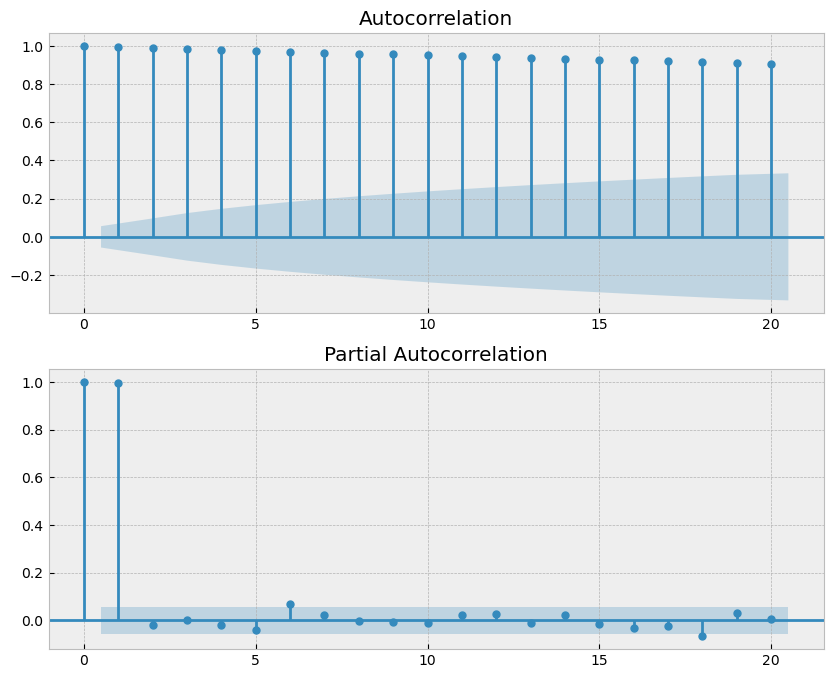

In [96]:
# 삼성전자 주식 데이터가 MA의 특성을 갖고 있는지, AR의 특성을 갖고있는지 plot으로 확인
# plot_acf(ts_log)
# plot_pacf(ts_log)
# plt.show()

# import statsmodels.graphics.tsaplots as sgt 
rcParams['figure.figsize'] = 10, 8
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

sgt.plot_acf(ts_log, lags = 20, ax = ax1) # 4주를 기준으로 시차 확인 
ax1.set_title('Autocorrelation')

sgt.plot_pacf(ts_log, lags = 20, ax = ax2)
ax2.set_title('Partial Autocorrelation')
plt.show()

> 1. 삼성전자 주식 데이터는 AR의 특징을 갖고 있고 1 이후 0으로 가까워지기 때문에 p =1로 설정할 수 있음   
<br>  

> 2. 1주 시차 이후의 데이터는 상관 없는 데이터이다를 확인할 수 있음  
<br>  

> 3. 자연스럽게 q = 0으로 설정  
<br>

#### 4-2. 차분으로 d 설정

#### 4-2-1. period = 20 세팅 

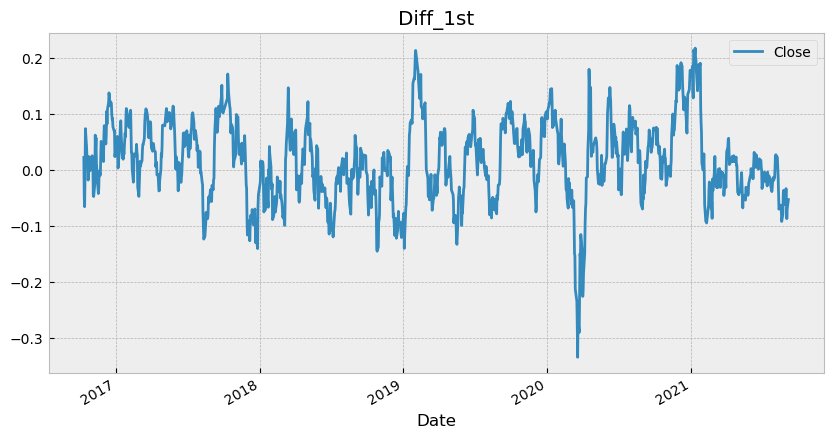

test_statistic             -5.177687
pvalue                      0.000010
num_of_lags                22.000000
num_of_observation       1185.000000
critical_values (1%)       -3.435880
critical_values (5%)       -2.863982
critical_values (10%)      -2.568070
dtype: float64


In [97]:
# period 기준으로 값을 비교함
# period = 20 
rcParams['figure.figsize'] = 10, 5
d_1 = ts_log.diff(periods=20).iloc[20:]
d_1.plot(title = 'Diff_1st')
plt.legend(loc = 'best')
plt.show()

augmented_dickey_fuller(d_1)

#### 4-2-2. period = 1 세팅 

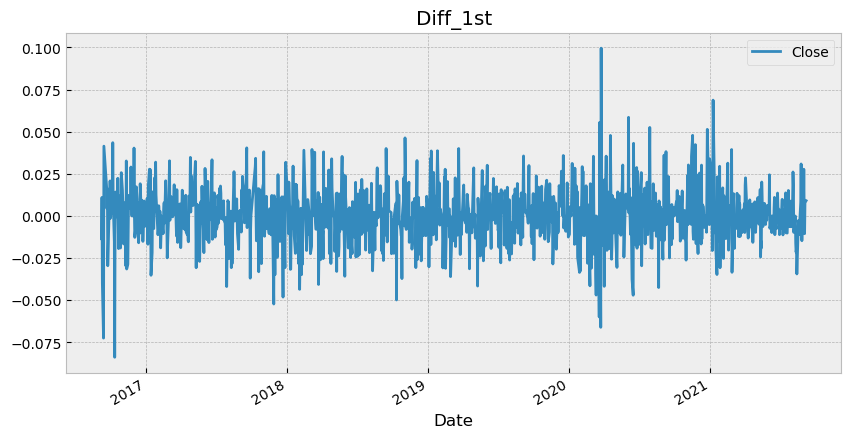

test_statistic            -34.159306
pvalue                      0.000000
num_of_lags                 0.000000
num_of_observation       1226.000000
critical_values (1%)       -3.435695
critical_values (5%)       -2.863900
critical_values (10%)      -2.568027
dtype: float64


In [98]:
# period 기준으로 값을 비교함
# period 1일 때 num of lags가 0으로 나옴 
rcParams['figure.figsize'] = 10, 5
d_12 = ts_log.diff(periods=1).iloc[1:]
d_12.plot(title = 'Diff_1st')
plt.legend(loc = 'best')
plt.show()

augmented_dickey_fuller(d_12)

#### 4-3. Origin data 와 Difference1(1차 차분_p = 20) 비교하여 Plot

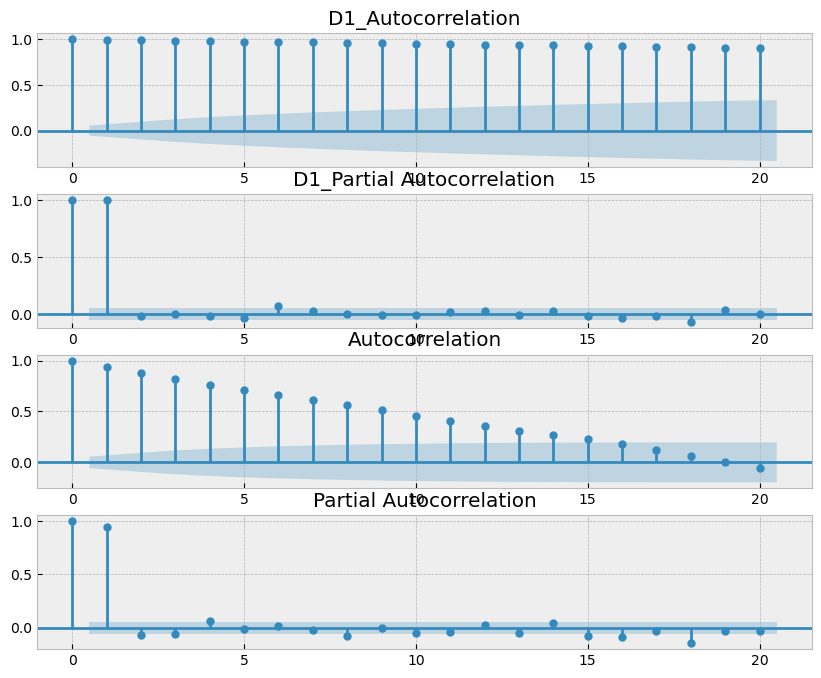

In [99]:
rcParams['figure.figsize'] = 10, 8
fig = plt.figure()
ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)
ax3 = fig.add_subplot(413)
ax4 = fig.add_subplot(414)

sgt.plot_acf(ts_log, lags = 20, ax = ax1) # 4주를 기준으로 시차 확인 
ax1.set_title('Origin_Autocorrelation')

sgt.plot_pacf(ts_log, lags = 20, ax = ax2)
ax2.set_title('Origin_Partial Autocorrelation')

sgt.plot_acf(d_1, lags = 20, ax = ax3) # 4주를 기준으로 시차 확인 
ax1.set_title('D1_Autocorrelation')

sgt.plot_pacf(d_1, lags = 20, ax = ax4)
ax2.set_title('D1_Partial Autocorrelation')
plt.show()

In [100]:
augmented_dickey_fuller_2(d_1)

test_statistic             -5.022881
pvalue                      0.000020
num_of_lags                21.000000
num_of_observation       1186.000000
critical_values (1%)       -3.435876
critical_values (5%)       -2.863980
critical_values (10%)      -2.568069
dtype: float64


> 1. min lag 가 0일 때는 diff하면 pvalue까지 0이 나옴  
<br> 

> 2. 우선 d = 1로 세팅한 뒤, 두개의 adfuller test 방법으로 진행해보기  
<br>

> 3. 즉, p = 1, q = 0, d = 1 으로 우선 세팅하여 ARIMA 진행 

#### 4-4. ARIMA MODEL Training 
`from statsmodels.tsa.arima_model import ARIMA`

#### 4-4-1. Model Build

In [101]:
import warnings
warnings.filterwarnings('ignore')

# Model Build & fit
model = ARIMA(train, order =(1,1,0)) # p, d, q 순서 
fit_model = model.fit() # disp = -1해도 동일한 값 나옴 
print(fit_model.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1104
Model:                 ARIMA(1, 1, 0)   Log Likelihood                2902.060
Method:                       css-mle   S.D. of innovations              0.017
Date:                Tue, 07 Sep 2021   AIC                          -5798.121
Time:                        21:27:41   BIC                          -5783.100
Sample:                             1   HQIC                         -5792.439
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0008      0.001      1.564      0.118      -0.000       0.002
ar.L1.D.Close     0.0180      0.030      0.599      0.549      -0.041       0.077
                                    Root

> AIC 값 낮게 나옴. 음수. AIC가 낮을수록 모델이 데이터에 더 적합해지고, 과적합을 방지함 

In [102]:
# predict 값 확인 
fit_model.predict()[:5]

Date
2016-09-07    0.000837
2016-09-08    0.000579
2016-09-09    0.001021
2016-09-12    0.000104
2016-09-13   -0.000483
dtype: float64

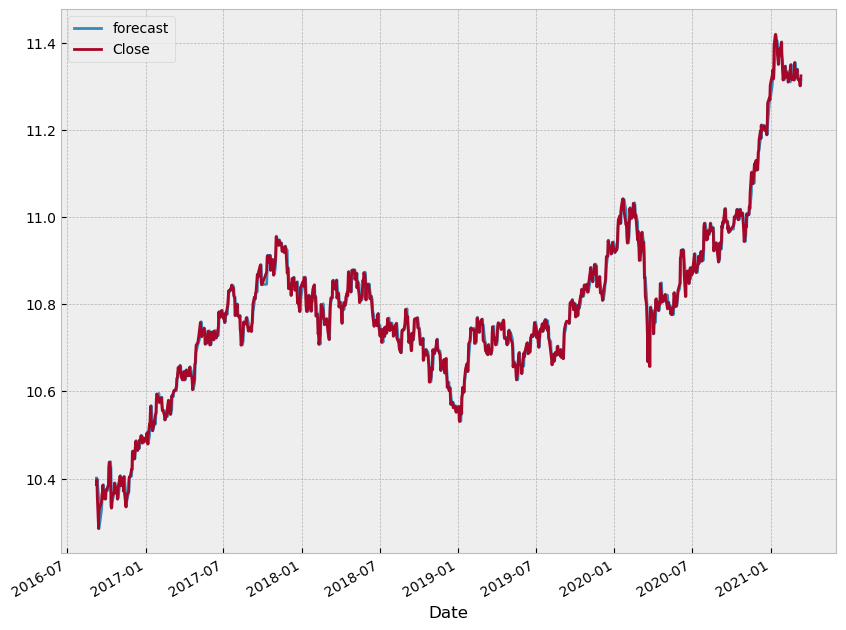

In [103]:
# predict 값 plot

fit_model.plot_predict()

> 실제 데이터와 forecast한 값이 거의 온전히 유사한 모양을 보이고 있음 

#### 4-3-2. Predict Forecast

#### 4-3-2-1. 정규화 데이터 Forecast 값 확인 

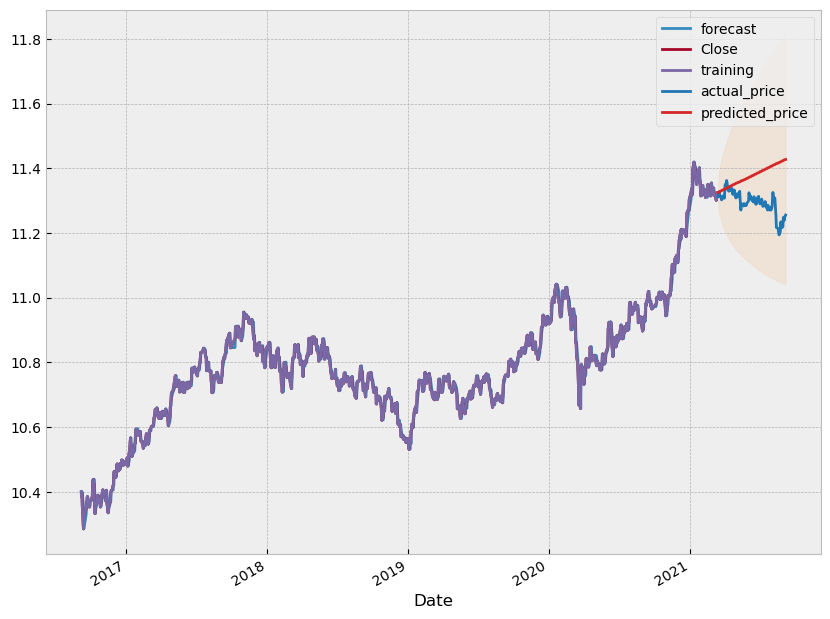

In [104]:
# 예측결과 : fc : .forecast의 첫번째 값 
# 예측결과의 하한 바운드 : se: .forecast의 첫번째 값 
# 예측결과의 상한 바운드 : conf: .forecast의 첫번째 값 

fc, se, conf = fit_model.forecast(len(test), alpha = 0.05) # 95% conf

# pd 형태로 만들기 
fc = pd.Series(fc, index = test.index) 
lower = pd.Series(conf[:, 0], index = test.index)
upper = pd.Series(conf[:, 1], index = test.index) 

# plot
rcParams['figure.figsize'] = 10,5
plt.plot(train, label = 'training')
plt.plot(test, c = 'tab:blue', label = 'actual_price')
plt.plot(fc, c= 'tab:red', label = 'predicted_price')
plt.fill_between(lower.index, lower, upper, color = 'tab:orange', alpha = 0.10)
plt.legend()
plt.show()


#### 4-3-2-2. 실데이터 Forecast 값 확인 
log화 시킨 데이터이니 실제 값 확인하기 위해 exp화 시킴 

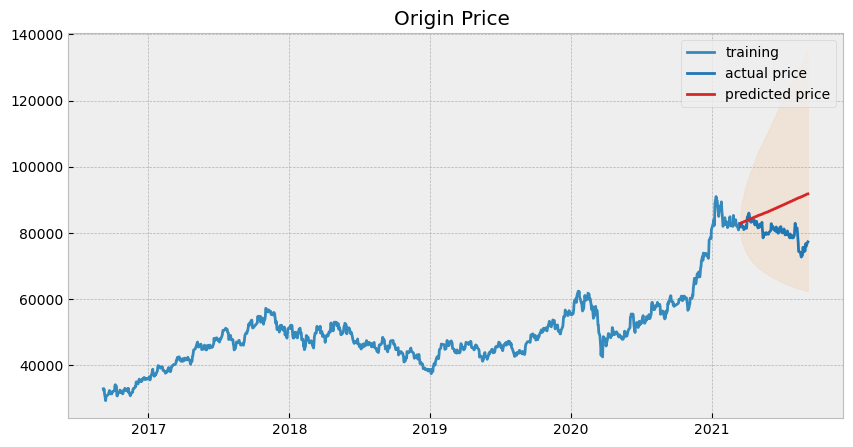

In [105]:
# log data 지수화 -> origin 범위로 만들기 
train_exp = np.exp(train)
test_exp = np.exp(test)
fc_exp = np.exp(fc)
lower_exp = np.exp(lower)
upper_exp = np.exp(upper)

# plot
rcParams['figure.figsize'] = 10,5
plt.plot(train_exp, label = 'training')
plt.plot(test_exp, c = 'tab:blue', label = 'actual price')
plt.plot(fc_exp, c= 'tab:red', label = 'predicted price')
plt.fill_between(lower_exp.index, lower_exp, upper_exp, color = 'tab:orange', alpha = 0.10)
plt.title('Origin Price ')
plt.legend()
plt.show()


### **4-2. ARIMA 모델 오차율 확인** 

In [106]:
# from sklearn.metrics import mean_squared_error, mean_absolute_error
# import math 

mse = mean_squared_error(test_exp, fc_exp)
print('MSE: ', mse)

mae = mean_absolute_error(test_exp, fc_exp)
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(test_exp, fc_exp))
print('RMSE: ', rmse)

mape = np.mean(np.abs(fc_exp - test_exp)/np.abs(test_exp))
print('MAPE: {:.2f}%'.format(mape*100))



MSE:  71476205.62154661
MAE:  6942.735638413468
RMSE:  8454.360154473348
MAPE: 8.84%


> 1. 8.84%의 오차율을 보임, 나쁘지 않으나 좋지도 않은 예측 결과가 나옴  
<br>

> 2. 그런데 plot으로 봤을 때는 값이 많이 차이나는 듯 보임  
<br>

> 3. Auto_Arima 사용해서 다시 진행해보려 함 

### 5. **ARIMA Model 사용_ Method 2 | AUTO_ARIMA**  
`from pmdarima.arima import auto_arima` 이용 

- Library Install 에러가 일어나서 단순 코드로 진행하고자 함 

In [107]:
# from pmdarima.arima import auto_arima
# model_2 = auto_arima(train, trace = True, error_action = 'ignore', 
#                     start_p = 0, start_q = 0, max_p = 20, max_q = 20)
# print(model_2.summary())

In [108]:
# 코드 참고 홍러닝(아래url 첨부)
import itertools

p = d = q = range(0, 4)
pdq = list(itertools.product(p,d,q))
# seasonal_pdq = [(x[0], x[1], x[2], 3) for x in list(itertools.product(p, d, q))]
pdq[:5]

[(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 0, 3), (0, 1, 0)]

In [109]:
import warnings
warnings.filterwarnings('ignore')

best_aic = np.inf
best_pdq = None
tmp_model = None
best_mdl = None

for param in pdq:
    try:
        tmp_mdl = ARIMA(train, order = param)
        res = tmp_mdl.fit()
        print('ARIMA{} = AIC: {}'.format(param, res.aic))
        if res.aic < best_aic:
            best_aic = res.aic
            best_pdq = param
            best_mdl= tmp_mdl
    except:
        continue

print('Best ARIMA{} model - AIC:{}'.format(best_pdq, best_aic))
    


ARIMA(0, 0, 0) = AIC: -418.24174575781694
ARIMA(0, 0, 1) = AIC: -1818.3501777255146
ARIMA(0, 0, 2) = AIC: -2852.597973264749
ARIMA(0, 0, 3) = AIC: -3547.7212370152624
ARIMA(0, 1, 0) = AIC: -5799.761694191178
ARIMA(0, 1, 1) = AIC: -5798.109491631727
ARIMA(0, 1, 2) = AIC: -5796.4393044059325
ARIMA(0, 1, 3) = AIC: -5795.92331741321
ARIMA(0, 2, 0) = AIC: -5049.503850164712
ARIMA(0, 2, 1) = AIC: -5772.556800478378
ARIMA(0, 2, 2) = AIC: -5783.055274381601
ARIMA(0, 2, 3) = AIC: -5769.575656365392
ARIMA(1, 0, 0) = AIC: -5794.894893144821
ARIMA(1, 0, 1) = AIC: -5793.384672456854
ARIMA(1, 0, 2) = AIC: -5791.865206198403
ARIMA(1, 0, 3) = AIC: -5791.03161541503
ARIMA(1, 1, 0) = AIC: -5798.120532014402
ARIMA(1, 1, 1) = AIC: -5796.163919935418
ARIMA(1, 1, 2) = AIC: -5794.870363971746
ARIMA(1, 1, 3) = AIC: -5795.963811396536
ARIMA(1, 2, 0) = AIC: -5362.497917088549
ARIMA(1, 2, 1) = AIC: -5776.631902630463
ARIMA(1, 2, 2) = AIC: -5780.4636075533745
ARIMA(1, 2, 3) = AIC: -5779.052465566174
ARIMA(2, 0, 0

[코드 참고페이지](https://hongl.tistory.com/99)

> Best ARIMA parameter 2,1,2 사용

In [110]:
# Model_fit
model_2 = ARIMA(train, order =(2,1,2)) # p, d, q 순서 
fit_model2 = model_2.fit() # disp = -1해도 동일한 값 나옴 
print(fit_model2.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1104
Model:                 ARIMA(2, 1, 2)   Log Likelihood                2911.303
Method:                       css-mle   S.D. of innovations              0.017
Date:                Tue, 07 Sep 2021   AIC                          -5810.607
Time:                        21:28:16   BIC                          -5780.566
Sample:                             1   HQIC                         -5799.244
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0008      0.001      1.580      0.114      -0.000       0.002
ar.L1.D.Close    -1.4732      0.010   -153.751      0.000      -1.492      -1.454
ar.L2.D.Close    -0.9604      0.009   -1

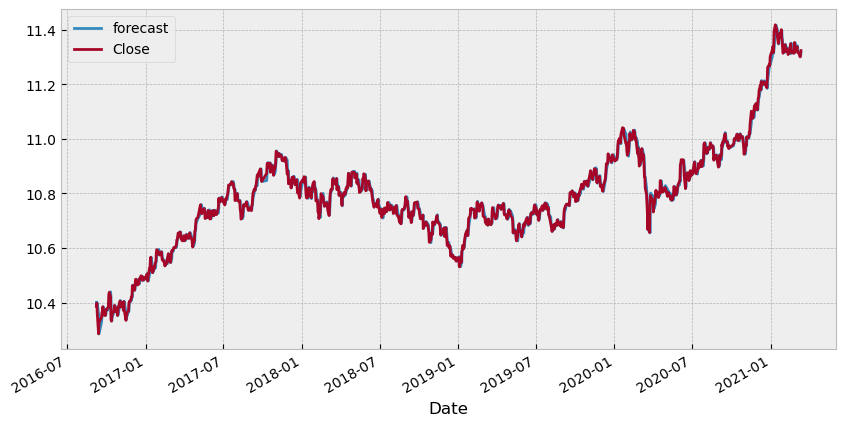

In [111]:
fit_model2.plot_predict()

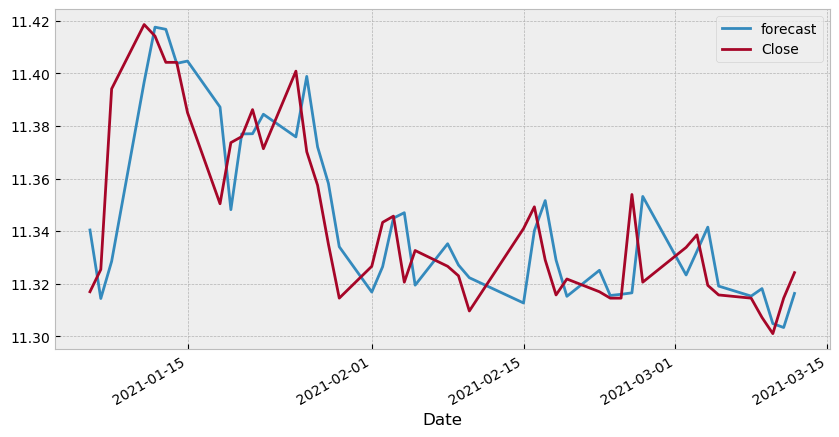

In [112]:
fit_model2.plot_predict(start = datetime.datetime(2021, 1, 6))

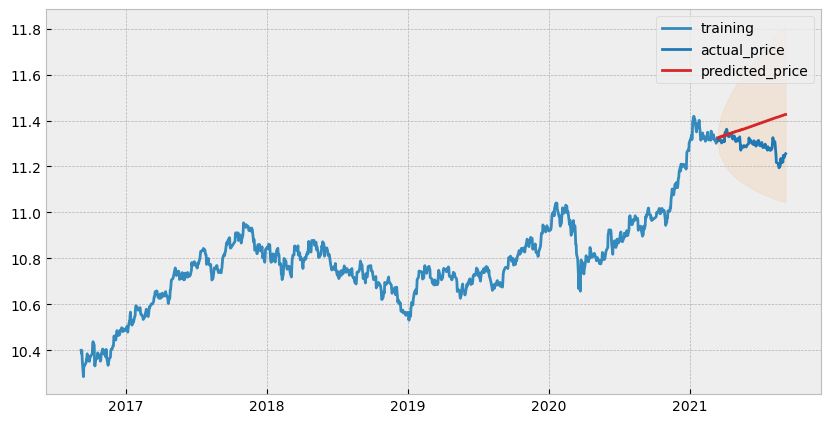

In [114]:

fc, se, conf = fit_model2.forecast(len(test), alpha = 0.05) # 95% conf

# pd 형태로 만들기 
fc = pd.Series(fc, index = test.index) 
lower = pd.Series(conf[:, 0], index = test.index)
upper = pd.Series(conf[:, 1], index = test.index) 

# plot
rcParams['figure.figsize'] = 10,5
plt.plot(train, label = 'training')
plt.plot(test, c = 'tab:blue', label = 'actual_price')
plt.plot(fc, c= 'tab:red', label = 'predicted_price')
plt.fill_between(lower.index, lower, upper, color = 'tab:orange', alpha = 0.10)
plt.legend()
plt.show()


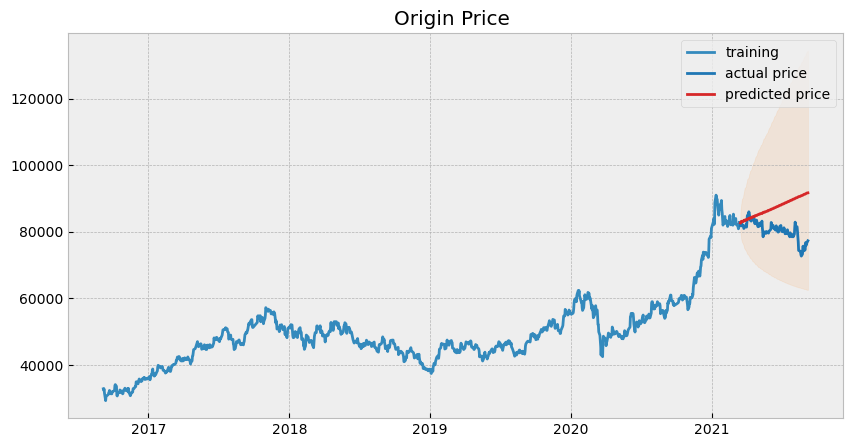

In [46]:
# log data 지수화 -> origin 범위로 만들기 
train_exp = np.exp(train)
test_exp = np.exp(test)
fc_exp = np.exp(fc)
lower_exp = np.exp(lower)
upper_exp = np.exp(upper)

# plot
rcParams['figure.figsize'] = 10,5
plt.plot(train_exp, label = 'training')
plt.plot(test_exp, c = 'tab:blue', label = 'actual price')
plt.plot(fc_exp, c= 'tab:red', label = 'predicted price')
plt.fill_between(lower_exp.index, lower_exp, upper_exp, color = 'tab:orange', alpha = 0.10)
plt.title('Origin Price ')
plt.legend()
plt.show()


In [47]:
# from sklearn.metrics import mean_squared_error, mean_absolute_error
# import math 

mse = mean_squared_error(test_exp, fc_exp)
print('MSE: ', mse)

mae = mean_absolute_error(test_exp, fc_exp)
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(test_exp, fc_exp))
print('RMSE: ', rmse)

mape = np.mean(np.abs(fc_exp - test_exp)/np.abs(test_exp))
print('MAPE: {:.2f}%'.format(mape*100))



MSE:  70243218.76036912
MAE:  6860.677142427965
RMSE:  8381.122762516316
MAPE: 8.73%


> 1. MAPE(오차율)이 0.1% 정도 떨어짐, 많은 차이가 없으나 더 낮은 오차율을 보임  
<br>

> 2. 추가적으로 다른 기업의 주가 변동 또한 예측해보고자 함  
<br>  

> 3. 카카오 & Alphabet 주가 예측 진행 

---------
---------
### **비고1. 카카오 Stock Price**

In [116]:
k_dataset_path = Path(os.getcwd() + '/data/kakao_035720.KS.csv')
kakao = pd.read_csv(k_dataset_path, index_col= 'Date', parse_dates= True)
# kakao.isnull().sum()

kakao_m= kakao.interpolate(method = 'time')
kakao_m.isnull().sum()

# 종가 데이터만 사용 
ts = kakao_m['Close']

1169


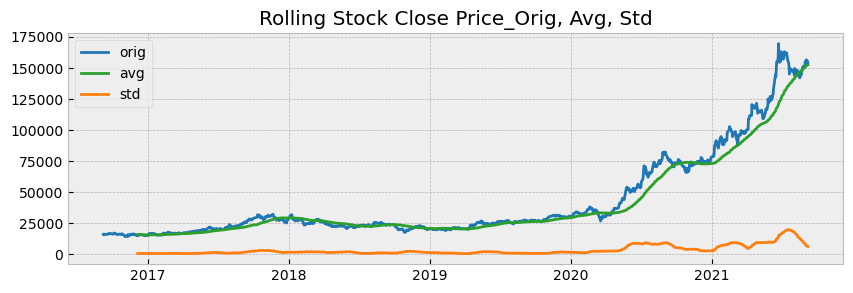

In [117]:
rcParams['figure.figsize'] = 10, 3
plot_rolling_data(ts, window = 60)

In [118]:
# augmented_dickey_fuller(ts)
# pvalue가 1에 가까움. 정규화 진행 

ts_log = np.log(ts)
augmented_dickey_fuller(ts_log)
# 많은 차이 보이지 않음. log화하지 않은 데이터로 ARIMA 진행하고자 함 
# 우선 train, test split 진행 

test_statistic              0.944028
pvalue                      0.993639
num_of_lags                 2.000000
num_of_observation       1225.000000
critical_values (1%)       -3.435699
critical_values (5%)       -2.863902
critical_values (10%)      -2.568028
dtype: float64


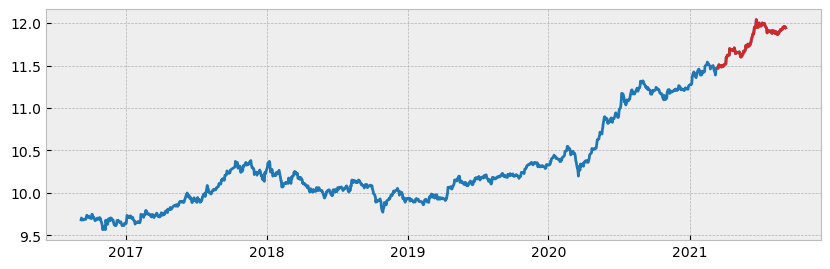

In [168]:
train, test = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

# red 부분이 우리가 예측할 부분 
plt.plot(ts_log, c ='tab:blue', label = 'train_data')
plt.plot(test, c ='tab:red', label = 'test_data')
plt.show()

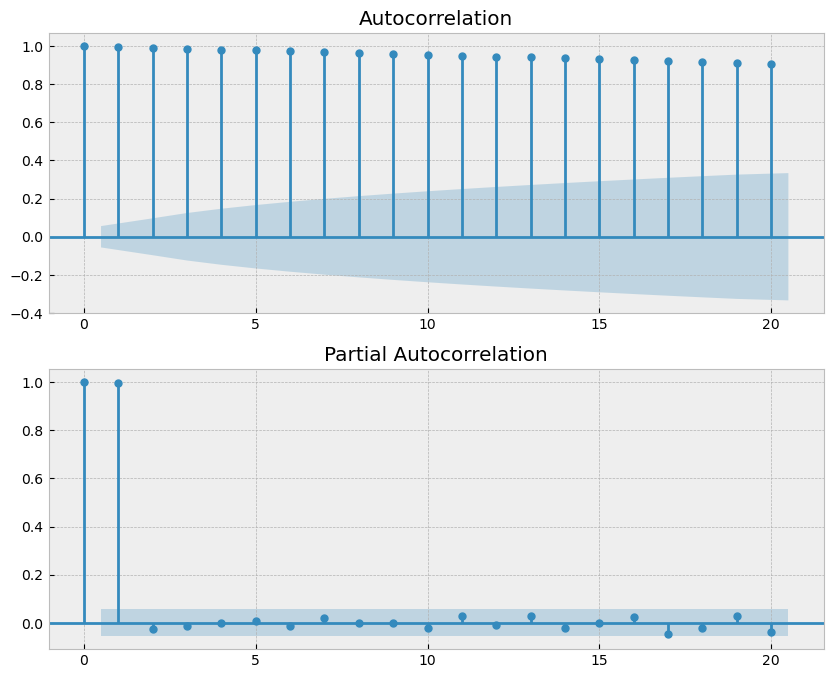

In [10]:
# rcParams['figure.figsize'] = 10, 8
# fig = plt.figure()
# ax1 = fig.add_subplot(211)
# ax2 = fig.add_subplot(212)

# sgt.plot_acf(ts, lags = 20, ax = ax1) # 4주를 기준으로 시차 확인 
# ax1.set_title('Autocorrelation')

# sgt.plot_pacf(ts, lags = 20, ax = ax2)
# ax2.set_title('Partial Autocorrelation')
# plt.show()

# # p = 1, q = 0

In [11]:
# d_3 = ts.diff(periods=1).iloc[1:]
# augmented_dickey_fuller(d_3)

test_statistic          -7.057805e+00
pvalue                   5.319039e-10
num_of_lags              1.900000e+01
num_of_observation       1.207000e+03
critical_values (1%)    -3.435779e+00
critical_values (5%)    -2.863938e+00
critical_values (10%)   -2.568046e+00
dtype: float64


> 위의 방법으로 찾아낸 ARIMA parameter는 1,0,1 그러나 더 나은 parameter 확인을 위해 아래와 같이 진행함 

In [21]:
# ARIMA parameter 확인
import itertools

p = d = q = range(0, 4)
pdq = list(itertools.product(p,d,q))
pdq[:5]

[(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 0, 3), (0, 1, 0)]

In [22]:
import warnings
warnings.filterwarnings('ignore')

best_aic = np.inf
best_pdq = None
tmp_model = None
best_mdl = None

for param in pdq:
    try:
        tmp_mdl = ARIMA(train, order = param)
        res = tmp_mdl.fit()
        print('ARIMA{} = AIC: {}'.format(param, res.aic))
        if res.aic < best_aic:
            best_aic = res.aic
            best_pdq = param
            best_mdl= tmp_mdl
    except:
        continue

print('Best ARIMA{} model - AIC:{}'.format(best_pdq, best_aic))
    


ARIMA(0, 0, 0) = AIC: 25114.361552856833
ARIMA(0, 0, 1) = AIC: 23641.779988882427
ARIMA(0, 1, 0) = AIC: 18198.47456929678
ARIMA(0, 1, 1) = AIC: 18179.983969361176
ARIMA(0, 1, 2) = AIC: 18172.174589005423
ARIMA(0, 1, 3) = AIC: 18174.087453079504
ARIMA(0, 2, 0) = AIC: 18774.061258406444
ARIMA(0, 2, 1) = AIC: 18185.330190807537
ARIMA(0, 2, 2) = AIC: 18167.951615484497
ARIMA(0, 2, 3) = AIC: 18160.88960844293
ARIMA(1, 0, 0) = AIC: 18231.400342686567
ARIMA(1, 1, 0) = AIC: 18176.909284887453
ARIMA(1, 1, 1) = AIC: 18176.972265875553
ARIMA(1, 2, 0) = AIC: 18511.912325717036
ARIMA(1, 2, 1) = AIC: 18165.18136789707
ARIMA(1, 2, 2) = AIC: 18165.509894376668
ARIMA(1, 2, 3) = AIC: 18162.81875141872
ARIMA(2, 0, 0) = AIC: 18207.983623051892
ARIMA(2, 1, 0) = AIC: 18174.915101837563
ARIMA(2, 1, 1) = AIC: 18175.79579917956
ARIMA(2, 1, 2) = AIC: 18155.48296048014
ARIMA(2, 2, 0) = AIC: 18452.245006504047
ARIMA(2, 2, 1) = AIC: 18163.624410321263
ARIMA(2, 2, 2) = AIC: 18164.456372314657
ARIMA(2, 2, 3) = AIC: 

In [37]:
import warnings
warnings.filterwarnings('ignore')

# Model_fit
model_3 = ARIMA(train, order =(2,1,2))
fit_model3 = model_3.fit() 
print(fit_model3.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1104
Model:                 ARIMA(2, 1, 2)   Log Likelihood                2626.171
Method:                       css-mle   S.D. of innovations              0.022
Date:                Tue, 07 Sep 2021   AIC                          -5240.341
Time:                        18:35:07   BIC                          -5210.301
Sample:                             1   HQIC                         -5228.979
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0016      0.001      2.197      0.028       0.000       0.003
ar.L1.D.Close    -0.2114      0.304     -0.696      0.486      -0.806       0.384
ar.L2.D.Close     0.1194      0.212     

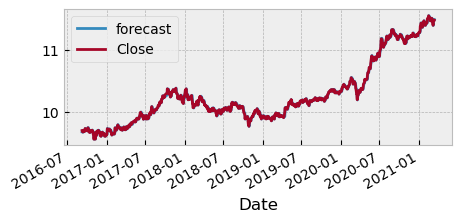

In [66]:
fit_model3.plot_predict()
plt.show()


> fitting 결과는 예측과 실측값이 거의 동일한 것으로 확인됨

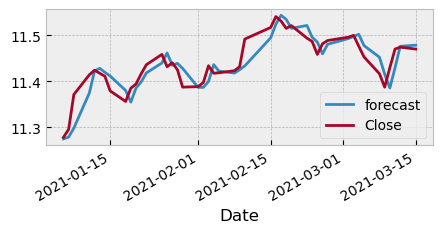

In [67]:
import datetime 

fit_model3.plot_predict(start = datetime.datetime(2021, 1, 6))
plt.show()


> 1. 모델 예측값이 실제값을 shifting한 것과 비슷한 형상을 보임. 이는 모델이 실제 과거 값을 바탕으로 다음 즉 현재의 값을 예측하는데 이전의 값을 사용하는 것이 현재의 값을 예측하는데에 좋다 라고 모델이 추론한 것   
<br>

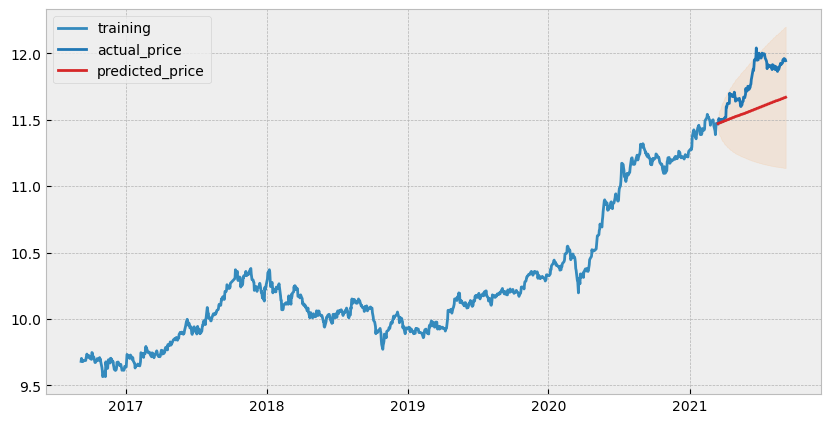

In [38]:
fc, se, conf = fit_model3.forecast(len(test), alpha = 0.05) # 95% conf

# pd 형태로 만들기 
fc = pd.Series(fc, index = test.index) 
lower = pd.Series(conf[:, 0], index = test.index)
upper = pd.Series(conf[:, 1], index = test.index) 

# plot
rcParams['figure.figsize'] = 10,5
plt.plot(train, label = 'training')
plt.plot(test, c = 'tab:blue', label = 'actual_price')
plt.plot(fc, c= 'tab:red', label = 'predicted_price')
plt.fill_between(lower.index, lower, upper, color = 'tab:orange', alpha = 0.10)
plt.legend()
plt.show()

> 1. 삼성전자 또한 fit 이후 predict plot을 그렸을 때 위와 비슷한 형상으로 이전의 data를 따라가는 형태를 보였으나, forecast 값은 이전의 추세를 따르지 않았음. 그래서 예측값의 오차율이 높지 않았던 것으로 생각됨.  
<br>  

> 2. 그러나 카카오는 현재 trend값이 높아서인지 그 추세를 따라가고 있음 (뒤의 높은 오차율 결과는 이로 인한 문제 occur이지 않나 생각됨)


In [39]:
# log data 지수화 -> origin 범위로 만들기 
train_exp = np.exp(train)
test_exp = np.exp(test)
fc_exp = np.exp(fc)
lower_exp = np.exp(lower)
upper_exp = np.exp(upper)

mse = mean_squared_error(test_exp, fc_exp)
print('MSE: ', mse)

mae = mean_absolute_error(test_exp, fc_exp)
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(test_exp, fc_exp))
print('RMSE: ', rmse)

mape = np.mean(np.abs(fc_exp - test_exp)/np.abs(test_exp))
print('MAPE: {:.2f}%'.format(mape*100))


MSE:  968635678.9320371
MAE:  26597.305835154657
RMSE:  31122.912442958117
MAPE: 18.56%


> 1. Kakao.Corp의 주가 오차율은 18.56%의 결과를 얻음. 너무 높은 오차율. 개선방안이 필요함  
<br>

> 2. 다른 library를 사용하면 결과값이 어떨까라는 의문이 들어 Prophet을 진행하고자 함 
<br>


### **비고1-2. Prophet() | Kakao Stock Price**

In [115]:
from prophet import Prophet

In [195]:
# train, test 데이터 다시 들고오기 

train, test = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

In [196]:
# prophet 사용을 위한 데이터 변경 -> ds, y로 변경 

train = train.to_frame()
train['ds'] = train.index
train.reset_index(drop = True, inplace = True)
train = train[['ds', 'Close']]
train.rename(columns = {'Close' : 'y'}, inplace = True)
train

,ds,y
0,2016-09-07,9.680344
1,2016-09-08,9.702595
2,2016-09-09,9.687816
3,2016-09-12,9.679093
4,2016-09-13,9.686575
...,...,...
1100,2021-03-09,11.387362
1101,2021-03-10,11.429544
1102,2021-03-11,11.470018
1103,2021-03-12,11.474185


In [197]:
model_31 = Prophet()
model_31.fit(train)
# model_31.summary()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [198]:
test_origin = test.copy()

test = test.to_frame()
test['ds'] = test.index
test.reset_index(drop = True, inplace = True)
test = test[['ds', 'Close']]
test.rename(columns = {'Close' : 'y'}, inplace = True)
test = test['ds'].to_frame()
test

,ds
0,2021-03-16
1,2021-03-17
2,2021-03-18
3,2021-03-19
4,2021-03-22
...,...
118,2021-09-01
119,2021-09-02
120,2021-09-03
121,2021-09-06


In [199]:
# forecast
forecast = model_31.predict(test)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
118,2021-09-01,12.433993,11.888236,13.055450
119,2021-09-02,12.435732,11.903261,13.066954
120,2021-09-03,12.437237,11.892396,13.083118
121,2021-09-06,12.429975,11.845304,13.095866
122,2021-09-07,12.432999,11.855739,13.089171


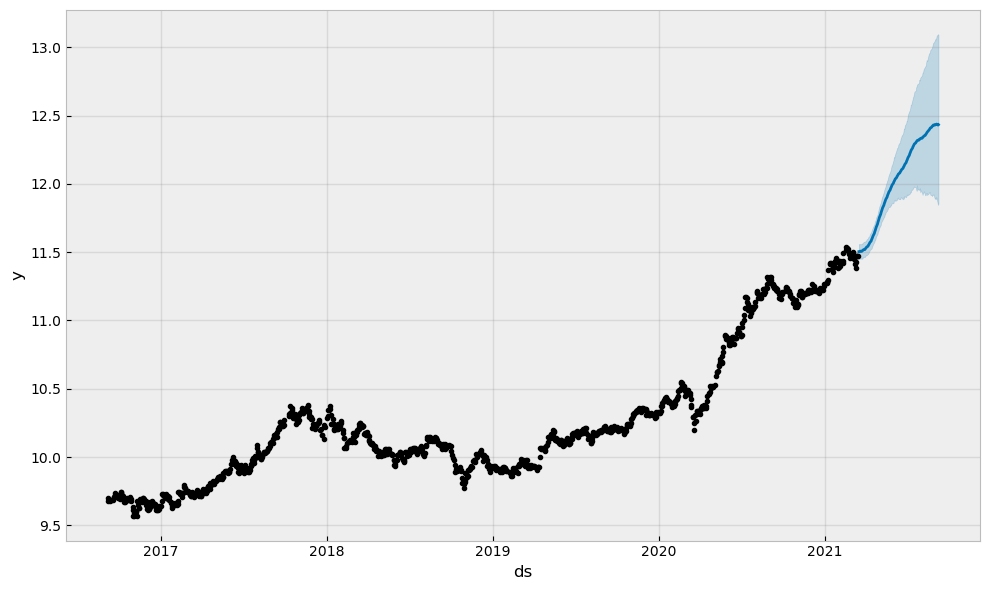

In [200]:
rcParams['figure.figsize'] = 8, 4
fig1 = model_31.plot(forecast)
plt.show()

In [201]:
# prophet predict를 통한 forecast 진행 

y_hat = forecast['yhat']
y_hat_exp = np.exp(y_hat)
y_hat_exp

0       99051.327170
1       99050.904517
2       99255.161910
3       99476.218818
4       99181.115991
           ...      
118    251197.136260
119    251634.343979
120    252013.231545
121    250189.739295
122    250947.401668
Name: yhat, Length: 123, dtype: float64

In [202]:
# test 데이터 실 주식값 exp화 시키기

test_origin_exp = np.exp(test_origin)
test_origin_exp.reset_index(drop = True, inplace = True)


In [194]:
test_origin_exp

0       95800.0
1       97000.0
2       99600.0
3       98500.0
4       98800.0
         ...   
118    154000.0
119    155000.0
120    156500.0
121    155500.0
122    154000.0
Name: Close, Length: 123, dtype: float64

In [203]:
# 예측 오차율 확인 

mape = np.mean(np.abs(test_origin_exp - y_hat_exp)/np.abs(y_hat_exp))
print('MAPE: {:.2f}%'.format(mape*100))

MAPE: 20.78%


> 1. 오히려 더 높은 오차율이 나옴. Deep한 knowledge로 진행한 것이 아니기 때문에라 생각됨. 추후 재 진행 필요 

### **비고2. Alphabet Stock Price 예측**

In [45]:
g_dataset_path = Path(os.getcwd() + '/data/GOOG.csv')
goog = pd.read_csv(g_dataset_path, index_col= 'Date', parse_dates= True)
# kakao.isnull().sum()

goog_m= goog.interpolate(method = 'time')
goog_m.isnull().sum()

# 종가 데이터만 사용 
ts = goog_m['Close']

1199


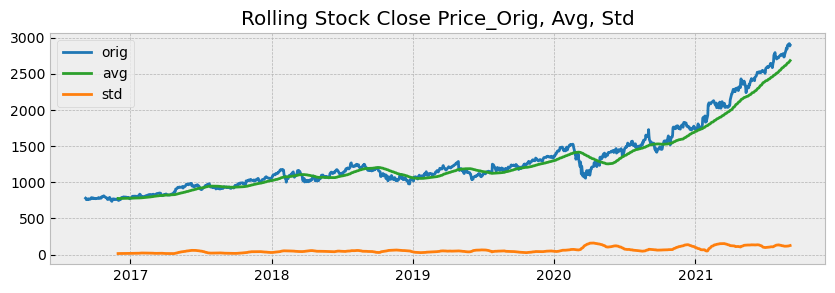

In [46]:
rcParams['figure.figsize'] = 10, 3
plot_rolling_data(ts, window = 60)

In [49]:
# augmented_dickey_fuller(ts)
# pvalue가 1에 가까움. 정규화 진행 

ts_log = np.log(ts)
augmented_dickey_fuller(ts_log)
# 많은 차이 보이지 않음. log화하지 않은 데이터로 ARIMA 진행하고자 함 
# 우선 train, test split 진행 

test_statistic              0.656344
pvalue                      0.988925
num_of_lags                 9.000000
num_of_observation       1248.000000
critical_values (1%)       -3.435601
critical_values (5%)       -2.863859
critical_values (10%)      -2.568004
dtype: float64


In [50]:
train, test = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]


In [51]:
import warnings
warnings.filterwarnings('ignore')

# ARIMA parameter 확인
import itertools

p = d = q = range(0, 4)
pdq = list(itertools.product(p,d,q))
pdq[:5]


best_aic = np.inf
best_pdq = None
tmp_model = None
best_mdl = None

for param in pdq:
    try:
        tmp_mdl = ARIMA(train, order = param)
        res = tmp_mdl.fit()
        print('ARIMA{} = AIC: {}'.format(param, res.aic))
        if res.aic < best_aic:
            best_aic = res.aic
            best_pdq = param
            best_mdl= tmp_mdl
    except:
        continue

print('Best ARIMA{} model - AIC:{}'.format(best_pdq, best_aic))
    


ARIMA(0, 0, 0) = AIC: -89.68043113621957
ARIMA(0, 0, 1) = AIC: -1548.3653517483826
ARIMA(0, 0, 2) = AIC: -2599.9316985847972
ARIMA(0, 0, 3) = AIC: -3399.4207781949935
ARIMA(0, 1, 0) = AIC: -5964.241203355387
ARIMA(0, 1, 1) = AIC: -5983.299427212285
ARIMA(0, 1, 2) = AIC: -5982.092074545899
ARIMA(0, 1, 3) = AIC: -5980.343030180738
ARIMA(0, 2, 0) = AIC: -5031.806637249605
ARIMA(0, 2, 1) = AIC: -5943.566024745429
ARIMA(0, 2, 2) = AIC: -5968.111255629536
ARIMA(0, 2, 3) = AIC: -5962.6571529728135
ARIMA(1, 0, 0) = AIC: -5959.022948590222
ARIMA(1, 0, 1) = AIC: -5976.823765066498
ARIMA(1, 0, 2) = AIC: -5975.860168449091
ARIMA(1, 0, 3) = AIC: -5974.28308775814
ARIMA(1, 1, 0) = AIC: -5983.911215515262
ARIMA(1, 1, 1) = AIC: -5981.917268331625
ARIMA(1, 1, 2) = AIC: -5986.978596471996
ARIMA(1, 1, 3) = AIC: -5989.645735230999
ARIMA(1, 2, 0) = AIC: -5472.021191400643
ARIMA(1, 2, 1) = AIC: -5968.740606839168
ARIMA(1, 2, 2) = AIC: -5947.8613110850965
ARIMA(1, 2, 3) = AIC: -5968.364002559454
ARIMA(2, 0, 

In [52]:
import warnings
warnings.filterwarnings('ignore')

# Model_fit
model_4 = ARIMA(train, order =(2,1,3))
fit_model4 = model_4.fit() 
print(fit_model4.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1131
Model:                 ARIMA(2, 1, 3)   Log Likelihood                3017.061
Method:                       css-mle   S.D. of innovations              0.017
Date:                Tue, 07 Sep 2021   AIC                          -6020.121
Time:                        18:40:59   BIC                          -5984.905
Sample:                             1   HQIC                         -6006.817
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0008      0.000      1.883      0.060   -3.49e-05       0.002
ar.L1.D.Close    -1.8090      0.036    -49.859      0.000      -1.880      -1.738
ar.L2.D.Close    -0.9372      0.028    -

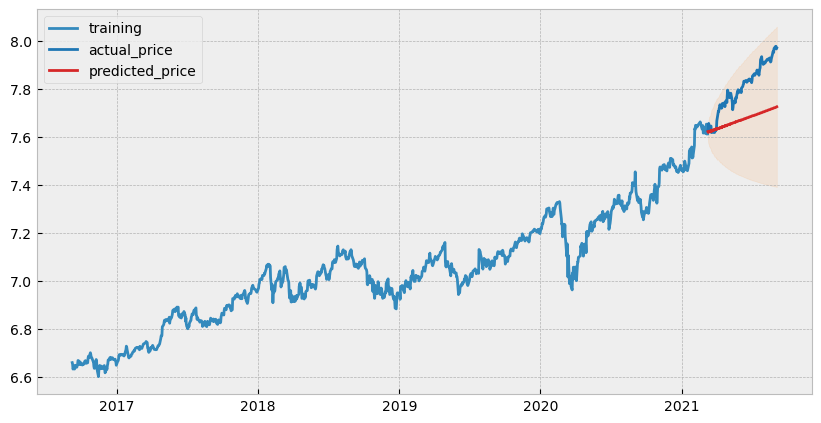

In [53]:
fc, se, conf = fit_model4.forecast(len(test), alpha = 0.05) # 95% conf

# pd 형태로 만들기 
fc = pd.Series(fc, index = test.index) 
lower = pd.Series(conf[:, 0], index = test.index)
upper = pd.Series(conf[:, 1], index = test.index) 

# plot
rcParams['figure.figsize'] = 10,5
plt.plot(train, label = 'training')
plt.plot(test, c = 'tab:blue', label = 'actual_price')
plt.plot(fc, c= 'tab:red', label = 'predicted_price')
plt.fill_between(lower.index, lower, upper, color = 'tab:orange', alpha = 0.10)
plt.legend()
plt.show()

In [54]:
# log data 지수화 -> origin 범위로 만들기 
train_exp = np.exp(train)
test_exp = np.exp(test)
fc_exp = np.exp(fc)
lower_exp = np.exp(lower)
upper_exp = np.exp(upper)

mse = mean_squared_error(test_exp, fc_exp)
print('MSE: ', mse)

mae = mean_absolute_error(test_exp, fc_exp)
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(test_exp, fc_exp))
print('RMSE: ', rmse)

mape = np.mean(np.abs(fc_exp - test_exp)/np.abs(test_exp))
print('MAPE: {:.2f}%'.format(mape*100))


MSE:  132670.26683988856
MAE:  317.71054447542474
RMSE:  364.2392988680499
MAPE: 12.27%


> Alphabet의 주가 오차율은 12.27%의 결과를 얻음

### 회고

- SARIMAX (ARIMA + Seasonality) 도 따로 진행해봐야겠음 _ error occur로 인해 진행하지 않음 
- 다른 idle을 이용하여 `from pmdarima.arima import auto_arima` 이용하고자 함 _ library collision occurred
- 급작스러운 trend를 갖고있는 kakao.corp의 경우 주가 오차율이 높게 나옴 -> 개선 방안 확인 
- 모든 작업을 function화 시키는 작업을 추후 진행하고자 함 
- model.fit(disp = )와 같은 변수값 변경이 어떠한 영향을 미치는지 정확히 알고자 함 -> 자료 서칭을 통해 찾아보았으나 정확히 알 수 없었음 
- Prophet을 이용하여 Kakao.Corp 주식 예측을 진행하였으나(ARIMA보다 더 나은 분석ㄱ밧을 도출한다고 알려져있지만) 더 높은 오차율을 보임. 사용방법을 더 익힌 후 진행하고자 함. 